In [3]:
import collections
from collections import defaultdict
import sys
import json
import random
from jsmin import jsmin
from io import StringIO
import numpy as np
import copy
import importlib
from functools import partial
import math
import os
import argparse
import compress_pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import SpectralClustering
import seaborn as sns

# script_n = os.path.basename(__file__).split('.')[0]
script_n = 'pc_clustering_211030_10'

sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')
import my_plot
importlib.reload(my_plot)
from my_plot import MyPlotData


In [4]:

z_mat, mask, mat_data, valid_pcs, z_scores = compress_pickle.load(
    '../pc_grc_pattern_similarity_zscore_211030_length_10_data.gz')

valid_pcs.remove('pc_43')  # no soma

identity_score = 0
default_score = 0
z_mat = []
for pc0 in valid_pcs:
    row = []
    for pc1 in valid_pcs:
        pair = tuple(sorted((pc0, pc1)))
        if pc0 == pc1:
            row.append(identity_score)
            continue
        if pair not in mat_data:
            row.append(default_score)
            continue
        row.append(z_scores[pair])
    z_mat.append(row)

X = np.array(z_mat)
# scale values so similarity is centered at 0.5 instead of at 0
min_val = np.min(X)
max_val = np.max(X)
scale_val = max(abs(min_val), abs(max_val))
X /= (2*scale_val)
X += 0.5

In [75]:
# X += 10
np.min(X)
X

array([[0.5       , 0.9471436 , 0.5       , 0.5       , 0.71581917,
        0.89152594, 0.5       , 0.74054962, 0.5       , 0.5       ,
        0.79156582, 0.5       , 0.80352532, 0.86152398, 0.74995214,
        0.5       , 0.5       , 0.5       , 0.92008349, 0.97235677,
        0.5       , 0.5       , 0.5       , 0.75136973, 0.5       ,
        0.74731926, 0.5       , 0.5       , 0.5       , 0.5       ],
       [0.9471436 , 0.5       , 0.5       , 0.5       , 0.87966727,
        0.93997015, 0.5       , 0.75106877, 0.5       , 0.5       ,
        0.88168856, 0.5       , 0.75015137, 1.        , 0.90237258,
        0.5       , 0.5       , 0.5       , 0.9746515 , 0.91455675,
        0.5       , 0.65620197, 0.5       , 0.81556411, 0.5       ,
        0.68699828, 0.5       , 0.56079754, 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       , 0.85109421, 0.5       ,
        0.5       , 0.61648121, 0.5       , 0.72628402, 0.80492328,
        0.49450669, 0.73975497, 0.7927981 , 0.

Height: 8.0, Aspect: 1.5


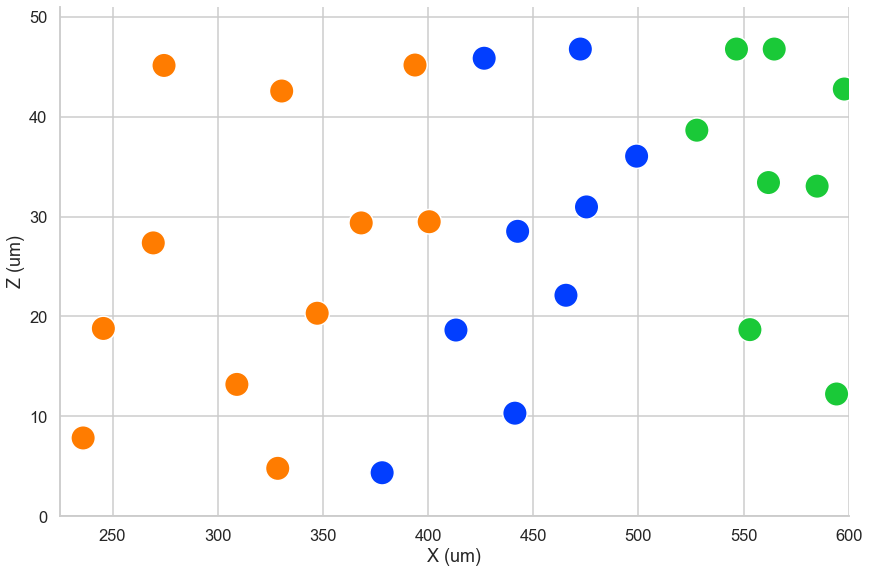

In [106]:
n_clusters = 3
af =SpectralClustering(
    n_clusters=n_clusters, affinity='precomputed', random_state=5, n_init=100,
).fit(X)
mpd = MyPlotData()
labels = set()
for i, pc in enumerate(valid_pcs):
    if pc not in loc_db:
        print(f'skipping {pc}')
        continue
    loc = loc_db[pc]
    label = af.labels_[i]
    mpd.add_data_point(
        x=loc[0]/4/1000, y=loc[1]/4/1000, z=loc[2]/1000, label=label,
        )
    labels.add(label)
n_colors = max(labels)
palette = sns.color_palette("bright", max(af.labels_)+1)
importlib.reload(my_plot); my_plot.my_relplot(
    mpd, kind='scatter', x="x", y="z", xlim=[225, 600], ylim=[0, 51], aspect=1.5, width=12,
    s=600, hue="label",
    hue_order=sorted(labels), palette=palette, y_axis_label='Z (um)', x_axis_label='X (um)', legend=False,
#     save_filename=f'{script_n}_min_length_{min_length}_n_clusters_{n_clusters}_beta_{beta}_gamma_{gamma}.svg',
    show=True,
    )


In [114]:
# X
print(af.labels_)
# print(len(X))
# valid_pcs
valid_pcs_clustered = defaultdict(list)
for i, pc in enumerate(valid_pcs):
    valid_pcs_clustered[af.labels_[i]].append(pc)
print(valid_pcs_clustered)
# valid_pcs_clustered
valid_pcs_clustered_list = []
# for k in sorted(valid_pcs_clustered.keys()):
for k in [1, 0, 2, 3]:
    valid_pcs_clustered_list.extend(valid_pcs_clustered[k])
# valid_pcs_clustered_list


[1 1 2 2 1 1 0 1 2 0 1 0 0 1 1 2 2 2 1 1 2 0 2 1 0 0 0 0 2 2]
defaultdict(<class 'list'>, {1: ['pc_57', 'pc_2', 'pc_26', 'pc_1', 'pc_7', 'pc_18', 'pc_17', 'pc_32', 'pc_31', 'purkinje_0', 'pc_25'], 2: ['pc_19', 'pc_53', 'pc_50', 'pc_22', 'pc_20', 'pc_21', 'pc_10', 'pc_23', 'pc_51', 'pc_3'], 0: ['pc_0', 'purkinje_1', 'pc_16', 'pc_4', 'pc_28', 'pc_9', 'pc_15', 'pc_48', 'pc_5']})


In [108]:
af.labels_
clusters = defaultdict(list)
pc_to_cluster = dict()
pc_ids = []
for pc_id, cluster in enumerate(af.labels_):
    if cluster == 2: cluster = 1
    elif cluster == 1: cluster = 2
    clusters[cluster].append(pc_id)
    pc_to_cluster[pc_id] = cluster
    pc_ids.append(pc_id)
pc_ids_ordered = sorted(pc_ids, key=lambda x: pc_to_cluster[x])
print(pc_ids_ordered)
print(clusters)

[6, 9, 11, 12, 21, 24, 25, 26, 27, 2, 3, 8, 15, 16, 17, 20, 22, 28, 29, 0, 1, 4, 5, 7, 10, 13, 14, 18, 19, 23]
defaultdict(<class 'list'>, {2: [0, 1, 4, 5, 7, 10, 13, 14, 18, 19, 23], 1: [2, 3, 8, 15, 16, 17, 20, 22, 28, 29], 0: [6, 9, 11, 12, 21, 24, 25, 26, 27]})


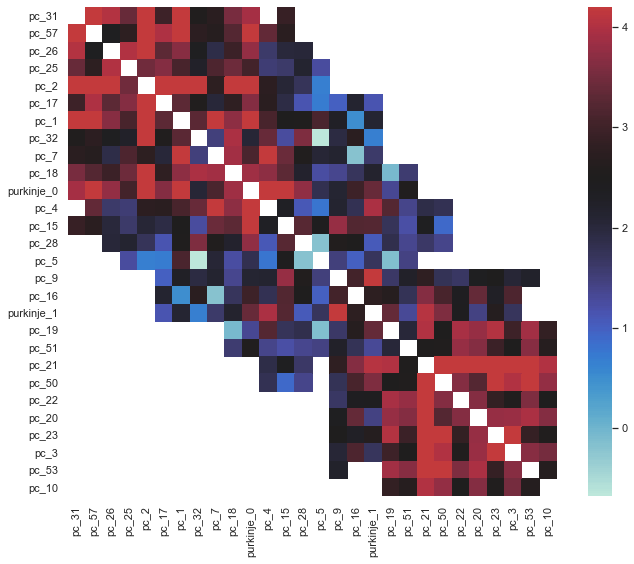

In [7]:
sim_matrix = []
mask = []
valid_pcs_clustered_list2 = copy.copy(valid_pcs_clustered_list)
valid_pcs_clustered_list2.remove('pc_48')  # no soma
valid_pcs_clustered_list2.remove('pc_0')  # very little dendrites in volume
for pc0 in valid_pcs_clustered_list2:
    row = []
    mask_row = []
    for pc1 in valid_pcs_clustered_list2:
        pair = tuple(sorted((pc0, pc1)))
        if pc0 == pc1:
            row.append(0)
            mask_row.append(1)
            continue
        if pair not in mat_data:
            row.append(0)
            mask_row.append(1)
            continue
        row.append(z_scores[pair])
        mask_row.append(0)
    sim_matrix.append(row)
    mask.append(mask_row)
mask = np.array(mask)
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
# cmap = sns.diverging_palette(240, 10, as_cmap=True)
cmap = "rocket"; center = 2
cmap = "rocket_r"; center = 2.5
cmap = "icefire"; center = 2.5
cmap = "icefire"; center = 2.5
sns.heatmap(sim_matrix,
            center=center,
            xticklabels=valid_pcs_clustered_list2, yticklabels=valid_pcs_clustered_list2,
            vmax=4.2,
#             vmax=1,
#             vmin=-1,
            square=True,
            mask=mask,
            cmap=cmap,
           )
# f.savefig(f'{script_n}_zscore.svg', bbox_inches='tight', transparent=True)

In [6]:
valid_pcs_clustered_list = [
    # 1, 0
     'pc_31',
     'pc_57',
     'pc_26',
     'pc_25',
     'pc_2',
     'pc_17',
     'pc_1',
     'pc_32',
     'pc_7',
     'pc_18',
     'purkinje_0',
    
     'pc_0',
    
     'pc_4',
     'pc_15',
     'pc_28',
     'pc_5',
    
     'pc_9',
     'pc_16',
     'purkinje_1',
    
     'pc_48',
    
     'pc_19',
     'pc_51',
     'pc_21',
     'pc_50',
     'pc_22',
     'pc_20',
     'pc_23',
     'pc_3',
     'pc_53',
     'pc_10',
]


In [270]:
linkage

array([[ 4.        ,  5.        ,  0.4665921 ,  2.        ],
       [20.        , 22.        ,  0.57608573,  2.        ],
       [ 1.        , 10.        ,  0.77251465,  2.        ],
       [ 8.        , 11.        ,  1.12590393,  2.        ],
       [15.        , 17.        ,  1.21371966,  2.        ],
       [ 0.        ,  6.        ,  1.25454806,  2.        ],
       [21.        , 26.        ,  1.44607133,  2.        ],
       [24.        , 25.        ,  1.63051682,  2.        ],
       [23.        , 29.        ,  1.96077469,  3.        ],
       [ 2.        ,  3.        ,  1.97816192,  2.        ],
       [ 7.        ,  9.        ,  2.03548419,  2.        ],
       [30.        , 33.        ,  2.05812128,  4.        ],
       [18.        , 36.        ,  2.33888904,  4.        ],
       [12.        , 13.        ,  2.74991396,  2.        ],
       [28.        , 39.        ,  2.83102239,  6.        ],
       [34.        , 35.        ,  2.91728676,  4.        ],
       [27.        , 40.

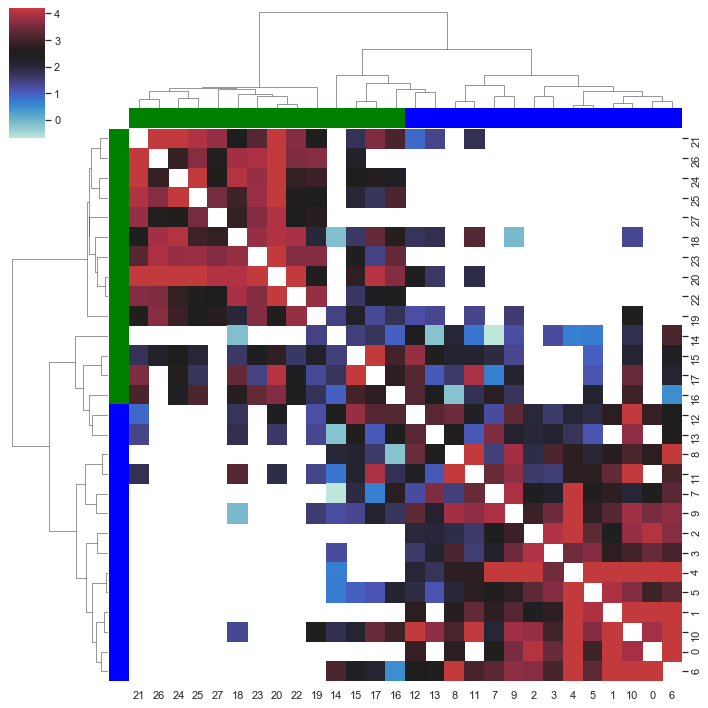

In [280]:
sim_matrix = []
mask = []
valid_pcs_clustered_list2 = copy.copy(valid_pcs_clustered_list)
valid_pcs_clustered_list2.remove('pc_48')  # no soma
valid_pcs_clustered_list2.remove('pc_0')  # very little dendrites in volume

arranged_colors = []
first = True
for pc in valid_pcs_clustered_list2:
    if pc == 'pc_5':
#     if pc == 'pc_9':
        first = False
    if first:
        arranged_colors.append('blue')
    else:
        arranged_colors.append('green')
        
for pc0 in valid_pcs_clustered_list2:
    row = []
    mask_row = []
    for pc1 in valid_pcs_clustered_list2:
        pair = tuple(sorted((pc0, pc1)))
        if pc0 == pc1:
            row.append(0)
            condensed_distance_matrix.append(0)
            mask_row.append(1)
            continue
        if pair not in mat_data:
            row.append(0)
            mask_row.append(1)
            condensed_distance_matrix.append(0)
            continue
        row.append(z_scores[pair])
        mask_row.append(0)
        if j >= i:
            condensed_distance_matrix.append(z_scores[pair])
    sim_matrix.append(row)
    mask.append(mask_row)
mask = np.array(mask)


condensed_distance_matrix = []
for i in range(len(sim_matrix)):
    for j in range(i+1, len(sim_matrix)):
        zscore = 6 - sim_matrix[i][j]
        if sim_matrix[i][j] == 0:
            zscore -= 1  # compensating for empty areas
        condensed_distance_matrix.append(zscore)

import scipy
linkage = scipy.cluster.hierarchy.linkage(condensed_distance_matrix,
# linkage = scipy.cluster.hierarchy.linkage(sim_matrix,
#                                           method='complete',  # might be best
#                                           method='single',  # kind of weird
#                                           method='average',  # kind of weird
#                                           method='weighted',
                                          
#                                           method='centroid',
#                                           method='median',
                                          method='ward',
#                                           optimal_ordering=True,
                                         )
# print(linkage)

cmap = "icefire"; center = 2.5
g = sns.clustermap(sim_matrix,
            square=True,
            mask=mask,
            cmap=cmap,
#               row_cluster=False,
               row_colors=arranged_colors,
               col_colors=arranged_colors,
            center=center,
            vmax=4.2,
                   row_linkage=my_ward_linkage, col_linkage=my_ward_linkage,
#                    row_linkage=linkage, col_linkage=linkage,
                   dendrogram_ratio=.15,
#                    truncate_mode='lastp'
              )
# g.savefig(f'{script_n}_hierarchical.svg', bbox_inches='tight', transparent=True)

In [279]:
# ward linkage, reordered
my_ward_linkage = [
       [ 4.        ,  5.        ,  0.4665921 ,  2.        ], # 28
       [20.        , 22.        ,  0.57608573,  2.        ], # 29
       [ 1.        , 10.        ,  0.77251465,  2.        ], # 30
       [ 8.        , 11.        ,  1.12590393,  2.        ], # 31
       [15.        , 17.        ,  1.21371966,  2.        ], # 32
       [ 0.        ,  6.        ,  1.25454806,  2.        ], # 33
       [21.        , 26.        ,  1.44607133,  2.        ], # 34
       [24.        , 25.        ,  1.63051682,  2.        ], # 35
       [23.        , 29.        ,  1.96077469,  3.        ], # 36
       [ 2.        ,  3.        ,  1.97816192,  2.        ], # 37
       [ 7.        ,  9.        ,  2.03548419,  2.        ], # 38
       [30.        , 33.        ,  2.05812128,  4.        ], # 39
       [18.        , 36.        ,  2.33888904,  4.        ], # 40
       [12.        , 13.        ,  2.74991396,  2.        ], # 41
       [28.        , 39.        ,  2.83102239,  6.        ],
       [34.        , 35.        ,  2.91728676,  4.        ],
       [27.        , 40.        ,  3.26742238,  5.        ],
       [16.        , 41.        ,  3.30437122,  3.        ],
       [43.        , 44.        ,  3.37212636,  9.        ],
       [46.        , 19.        ,  3.62496052, 10.        ],
       [37.        , 42.        ,  3.78632544,  8.        ],
       [31.        , 38.        ,  3.95616552,  4.        ], # 49
       [32.        , 45.        ,  4.32409911,  5.        ], # 50
       [49.        , 48.        ,  5.57655833, 12.        ], # 51
       [14.        , 50.        ,  5.64250834,  6.        ], # 52
       [52.        , 51.        , 10.15209518, 18.        ],
       [47.        , 53.        , 16.49257447, 28.        ]]

In [256]:
# complete linkage, reordered
my_linkage = [
       [ 4.        ,  5.        ,  0.4665921 ,  2.        ], # 28
       [20.        , 22.        ,  0.57608573,  2.        ], # 29
       [ 1.        , 10.        ,  0.77251465,  2.        ], # 30
       [ 8.        , 11.        ,  1.12590393,  2.        ], # 31
       [15.        , 17.        ,  1.21371966,  2.        ], # 32
       [ 6.        ,  0.        ,  1.25454806,  2.        ], # 33
       [21.        , 26.        ,  1.44607133,  2.        ], # 34
       [24.        , 25.        ,  1.63051682,  2.        ], # 35
       [ 2.        ,  3.        ,  1.97816192,  2.        ], # 36
       [ 9.        ,  7.        ,  2.03548419,  2.        ], # 37
       [18.        , 29.        ,  2.05134659,  3.        ], # 38
       [33.        , 30.        ,  2.07384565,  4.        ], # 39
       [23.        , 35.        ,  2.20651097,  3.        ], # 
       [36.        , 28.        ,  2.68256873,  4.        ], # 
       [12.        , 13.        ,  2.74991396,  2.        ], # 
       [34.        , 40.        ,  3.1191235 ,  5.        ], # 
       [32.        , 16.        ,  3.21825935,  3.        ], # 
       [27.        , 19.        ,  3.33512964,  2.        ], # 
       [38.        , 43.        ,  3.49575641,  8.        ], # 
       [41.        , 39.        ,  3.61156901,  8.        ], # 
       [47.        , 37.        ,  3.94178509, 10.        ], # 
       [45.        , 46.        ,  3.96618988, 10.        ], # 
       [31.        , 42.        ,  4.89223624,  4.        ], # 
       [48.        , 50.        ,  5.        , 14.        ], # 
       [44.        , 49.        ,  5.        , 13.        ], # 
       [14.        , 52.        ,  6.14418256, 14.        ], # 
       [51.        , 53.        ,  6.68131149, 28.        ]] # 

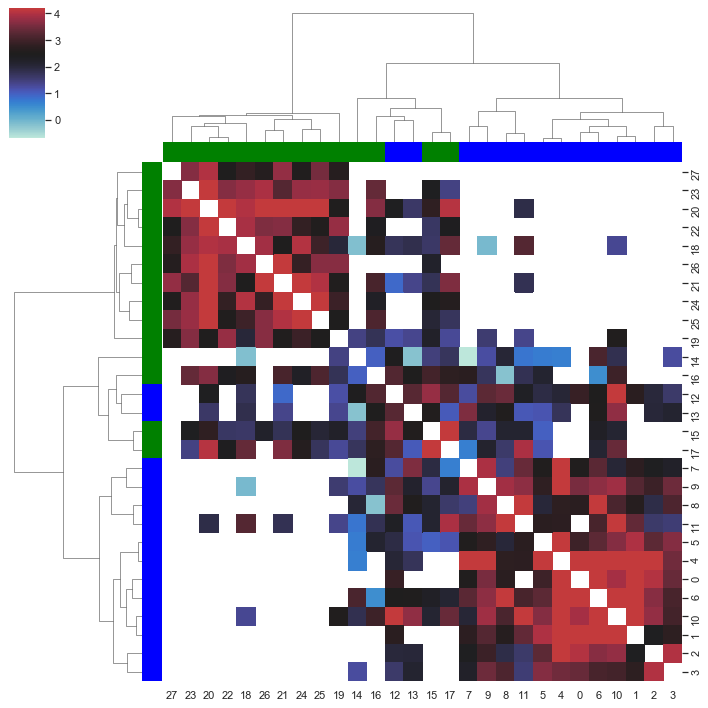

In [99]:

import scipy
linkage = scipy.cluster.hierarchy.linkage(condensed_distance_matrix,
                                          method='ward',
                                          optimal_ordering=True,
                                         )
cmap = "icefire"; center = 2.5
g = sns.clustermap(sim_matrix,
            square=True,
            mask=mask,
            cmap=cmap,
#               row_cluster=False,
               row_colors=arranged_colors,
               col_colors=arranged_colors,
            center=center,
            vmax=4.2,
                   row_linkage=linkage, col_linkage=linkage,
              )
# g.savefig(f'{script_n}_hierarchical.svg', bbox_inches='tight', transparent=True)

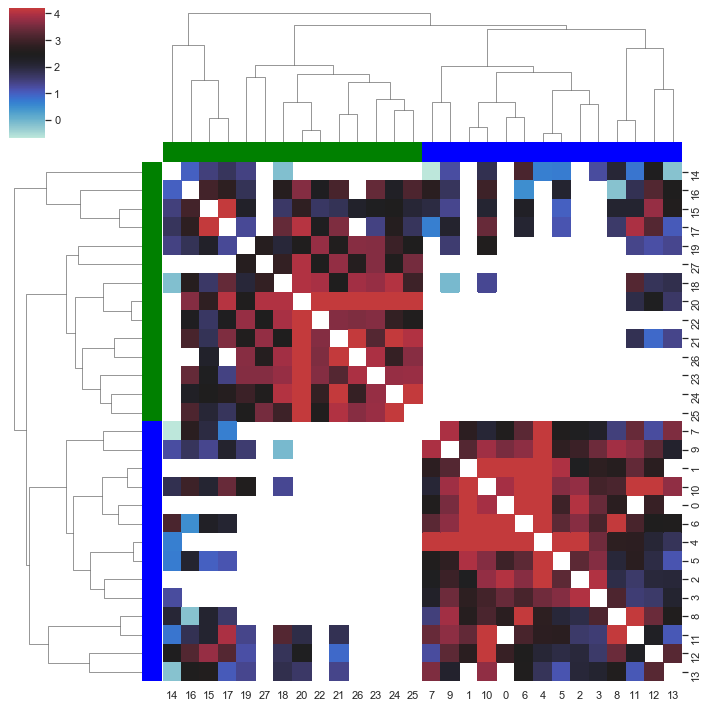

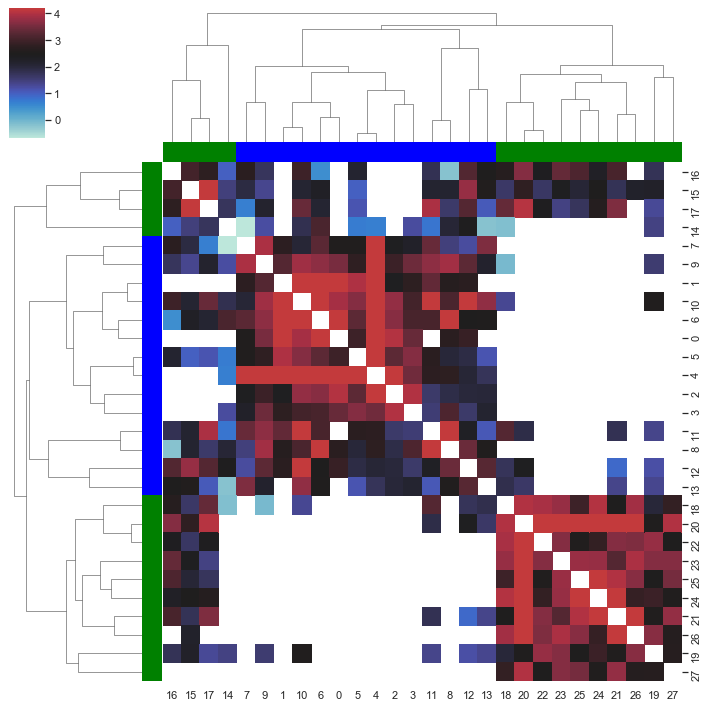

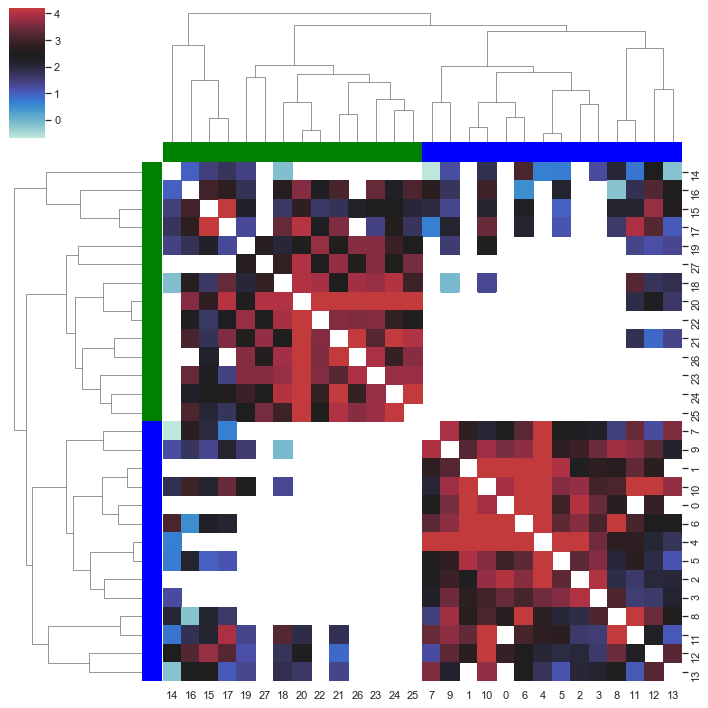

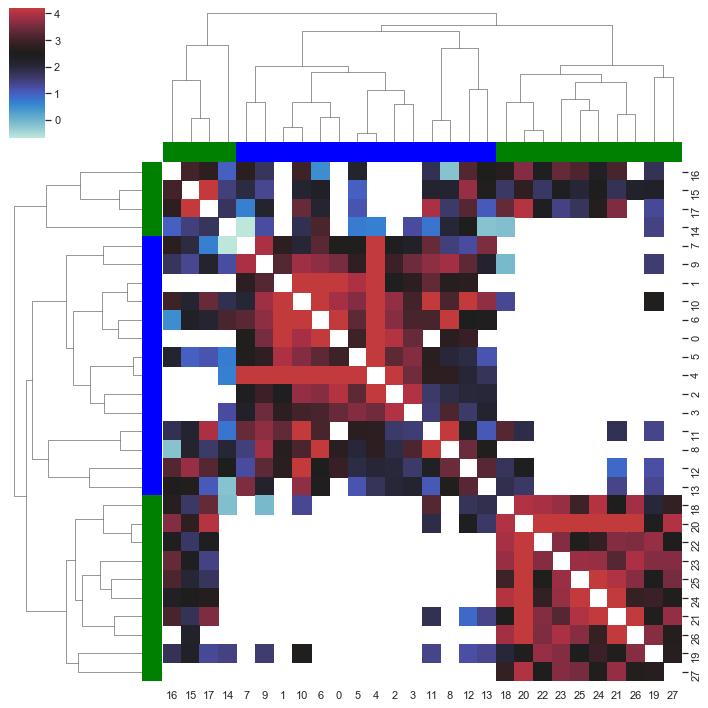

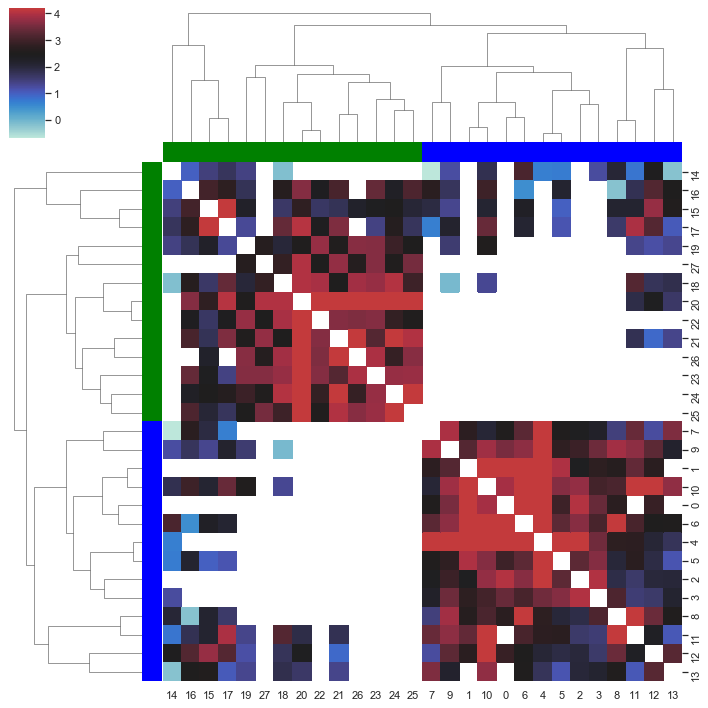

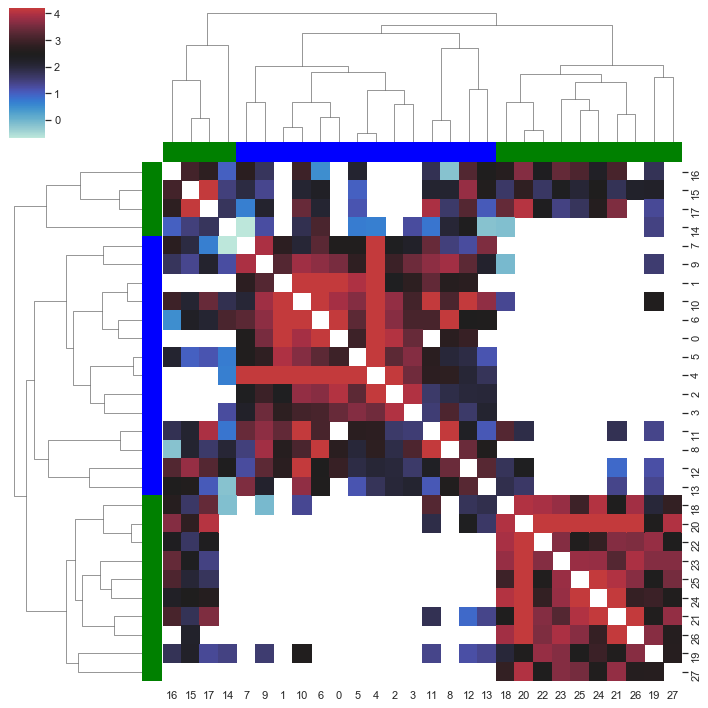

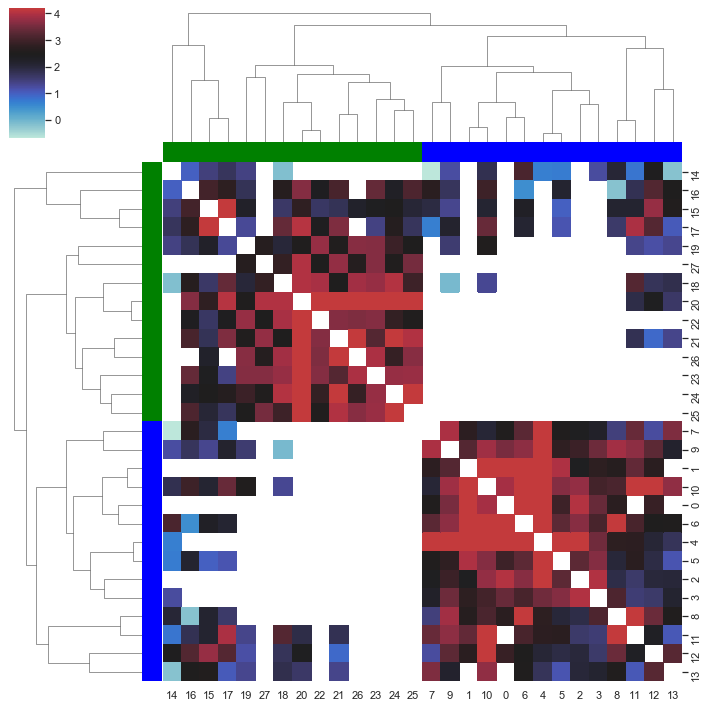

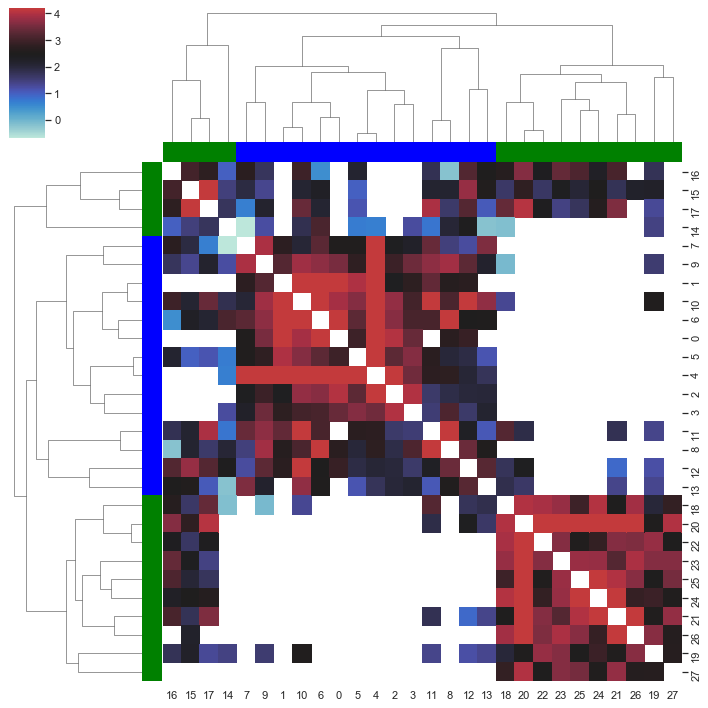

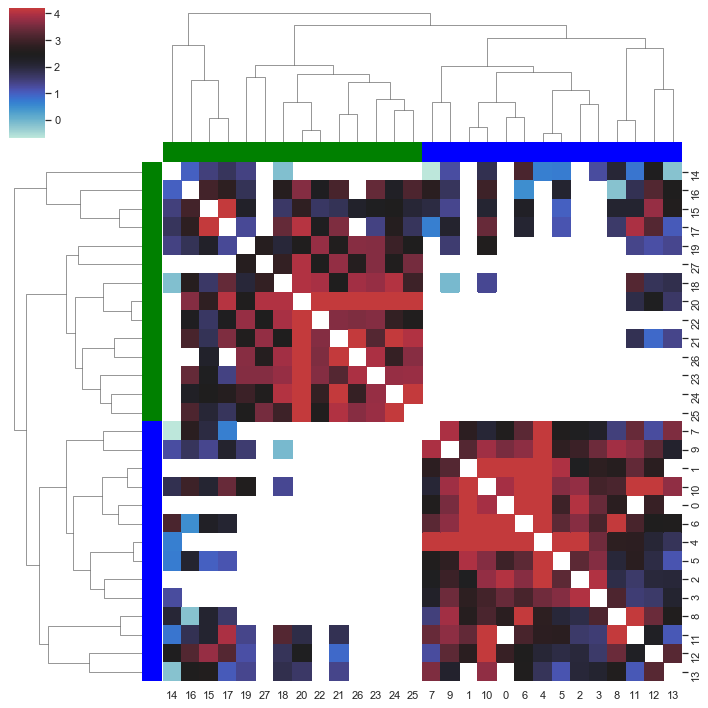

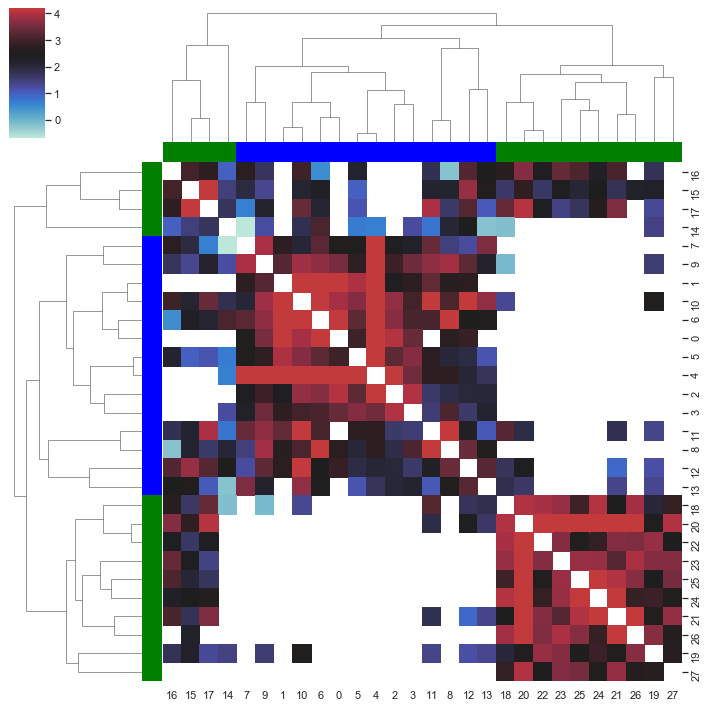

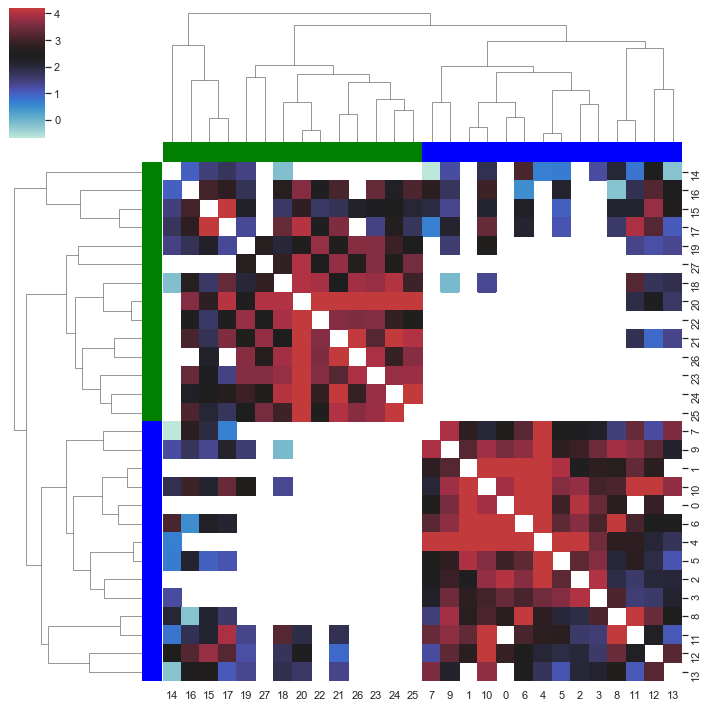

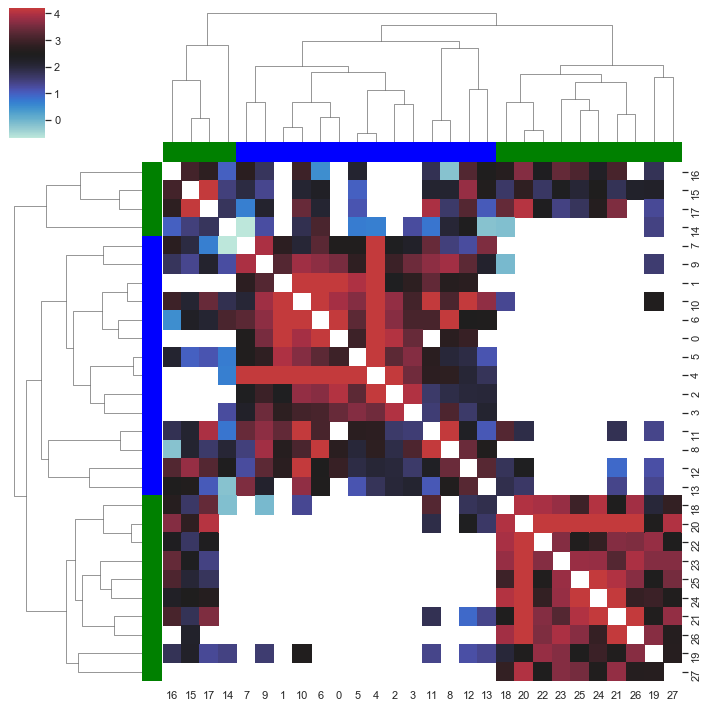

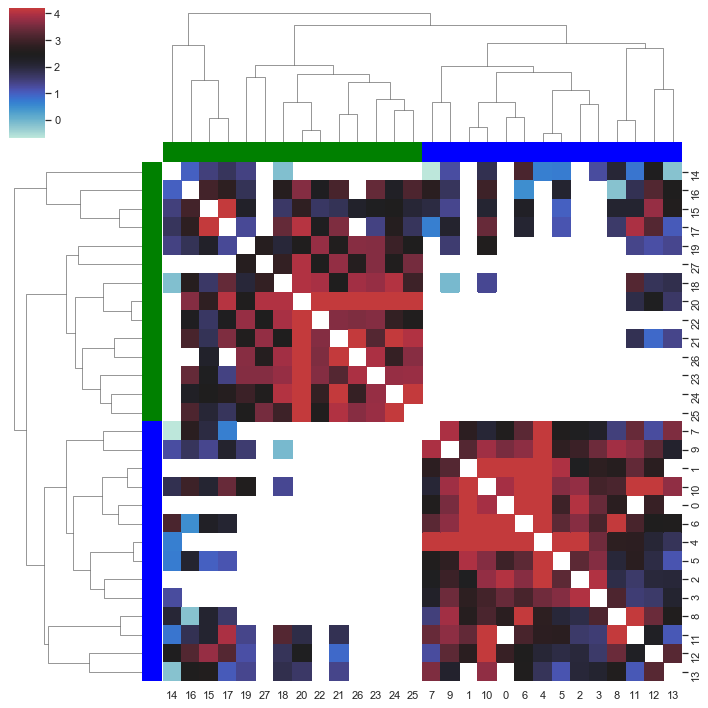

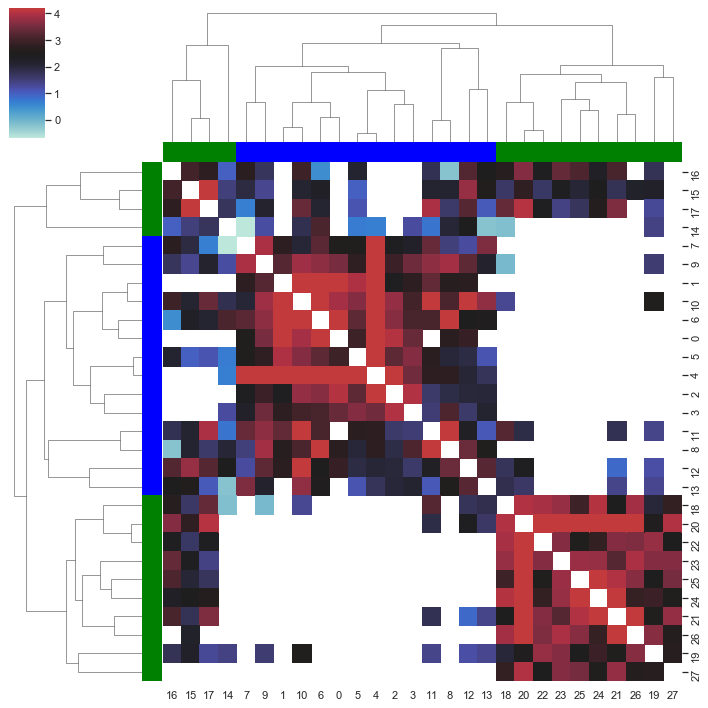

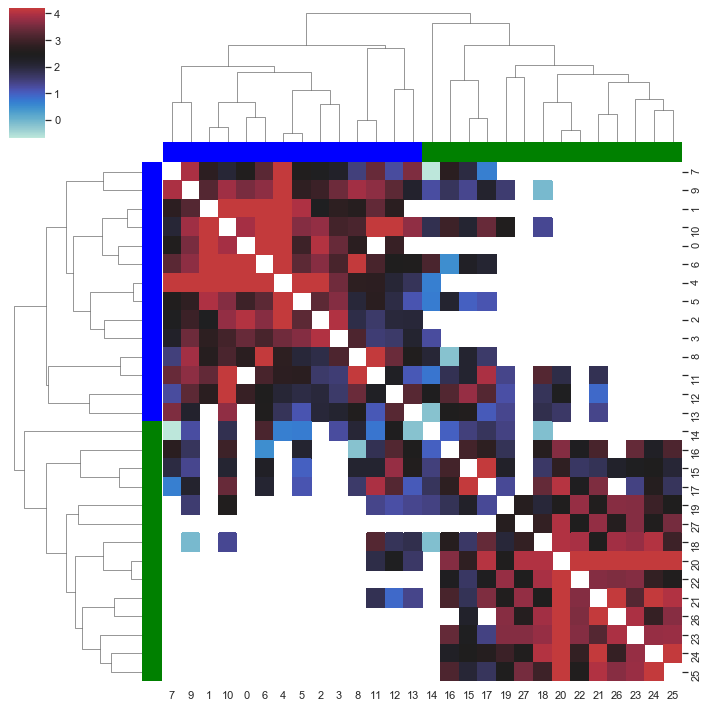

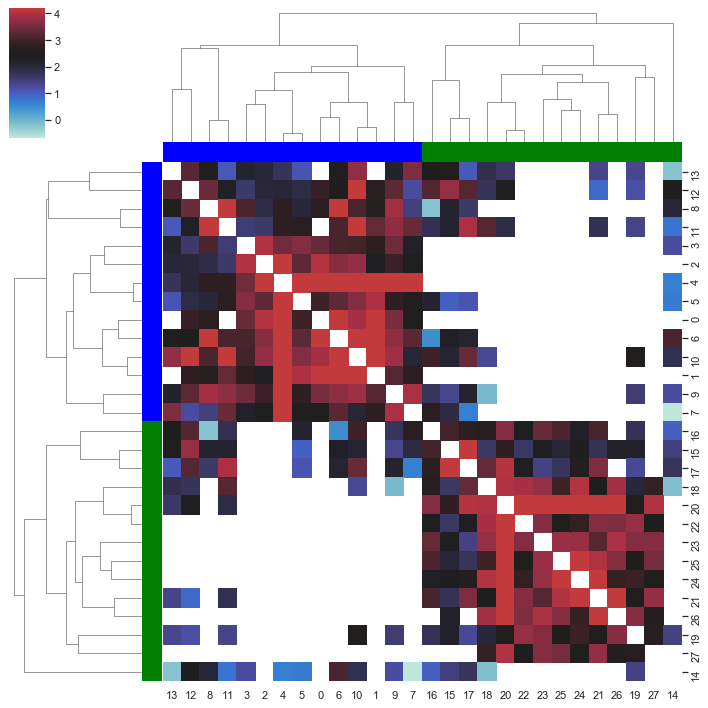

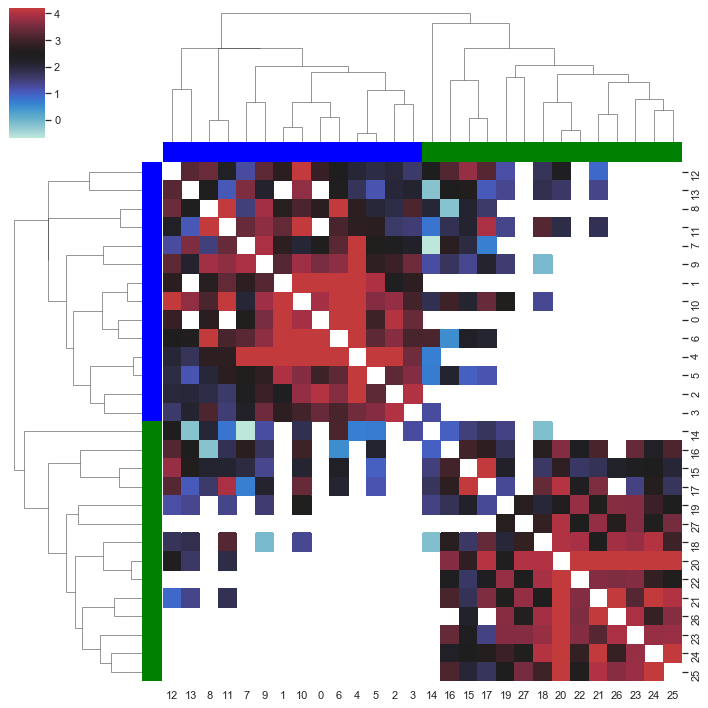

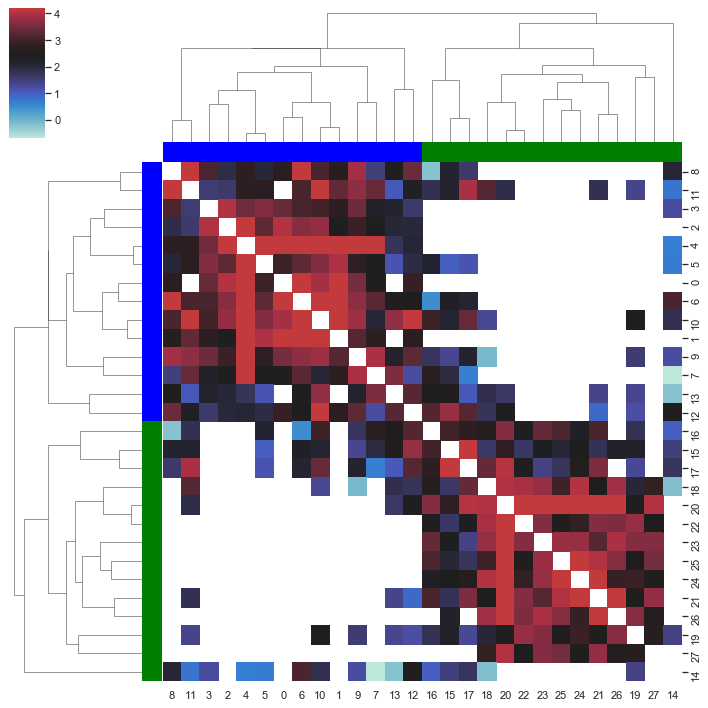

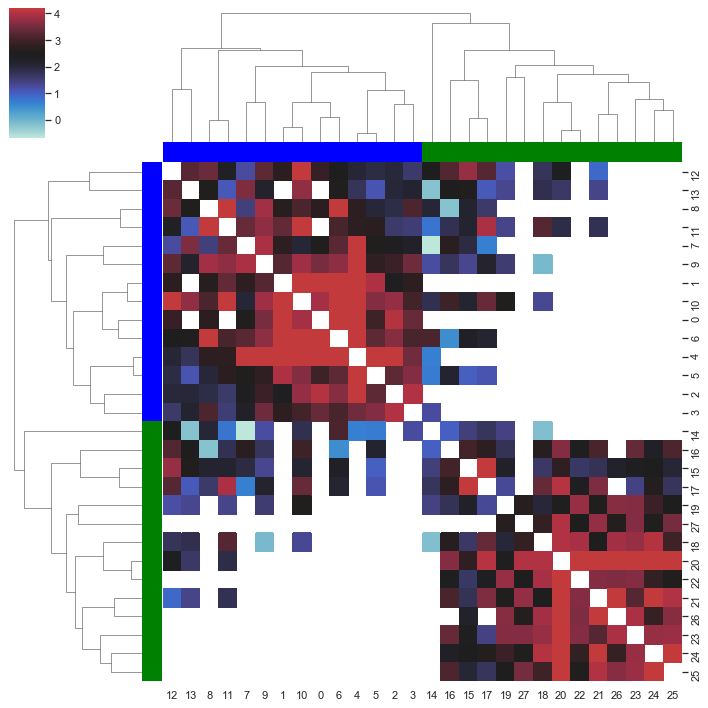

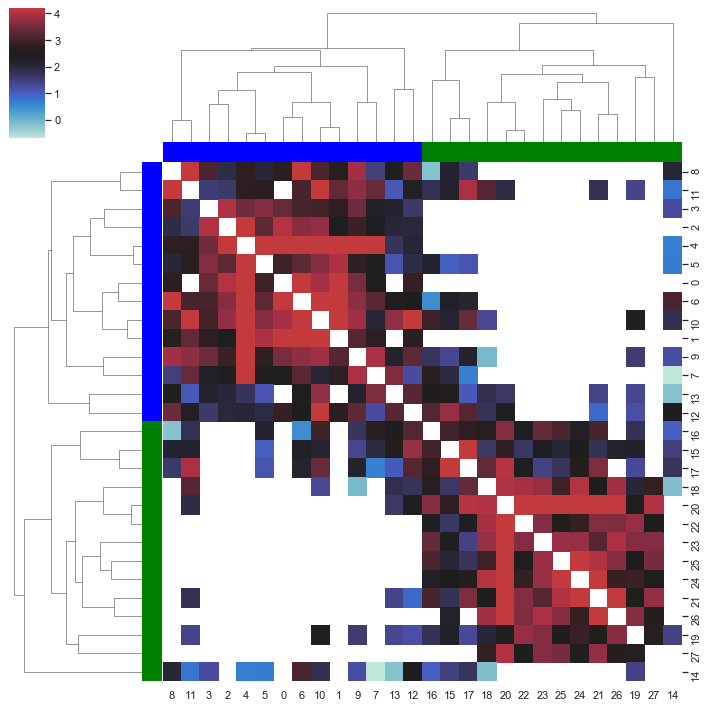

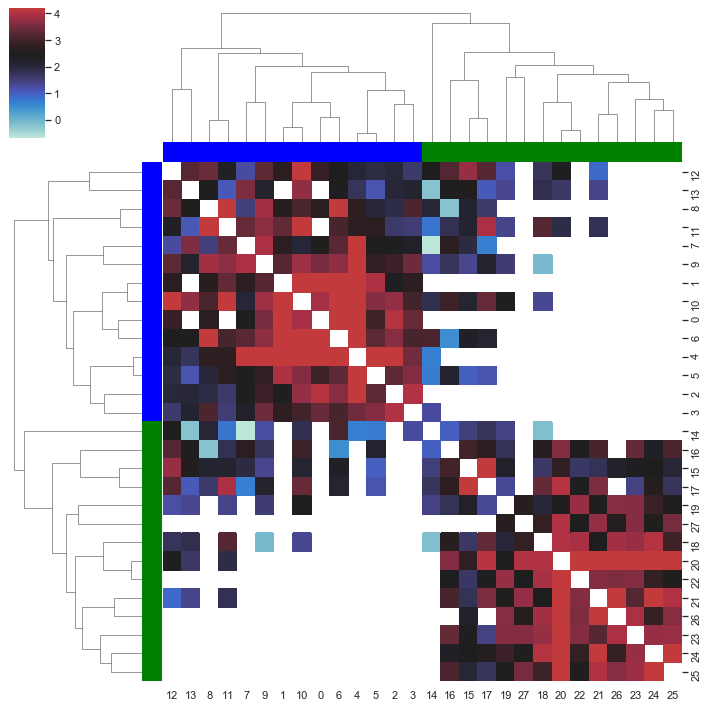

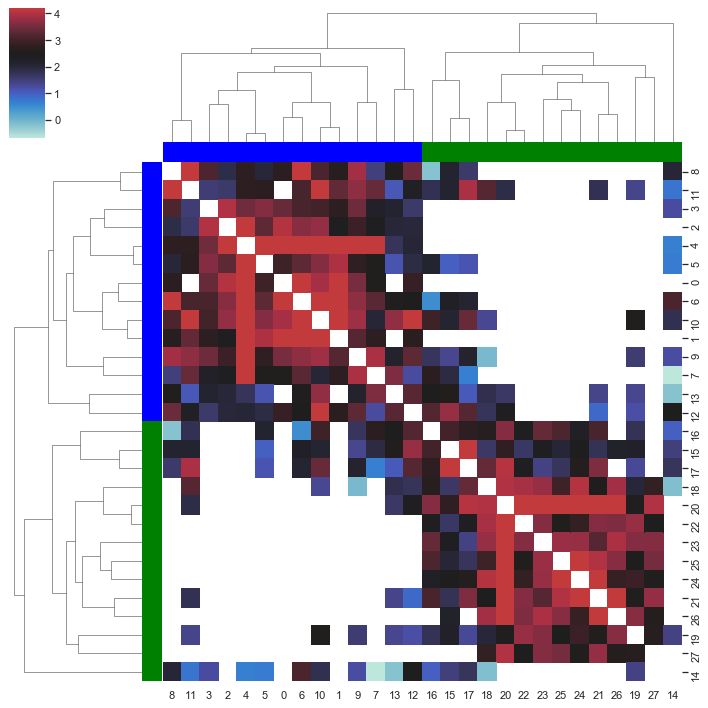

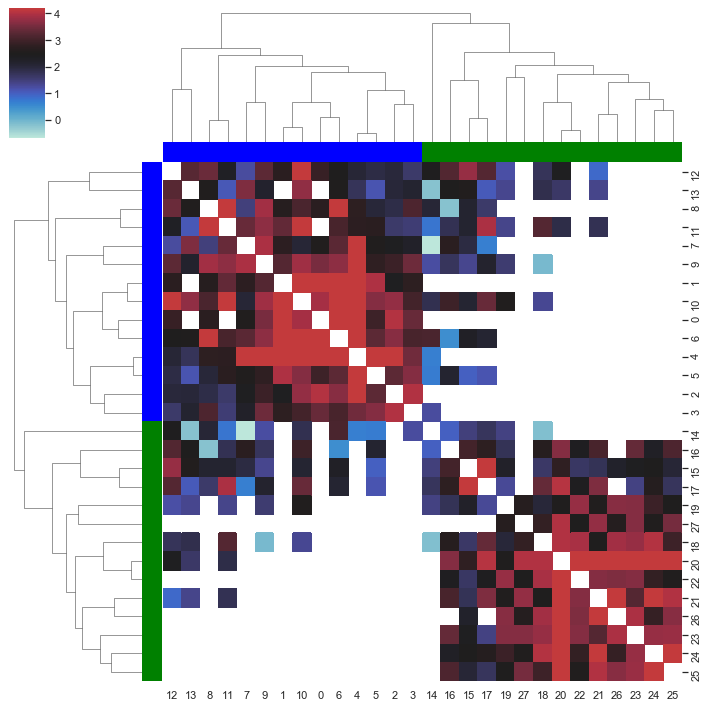

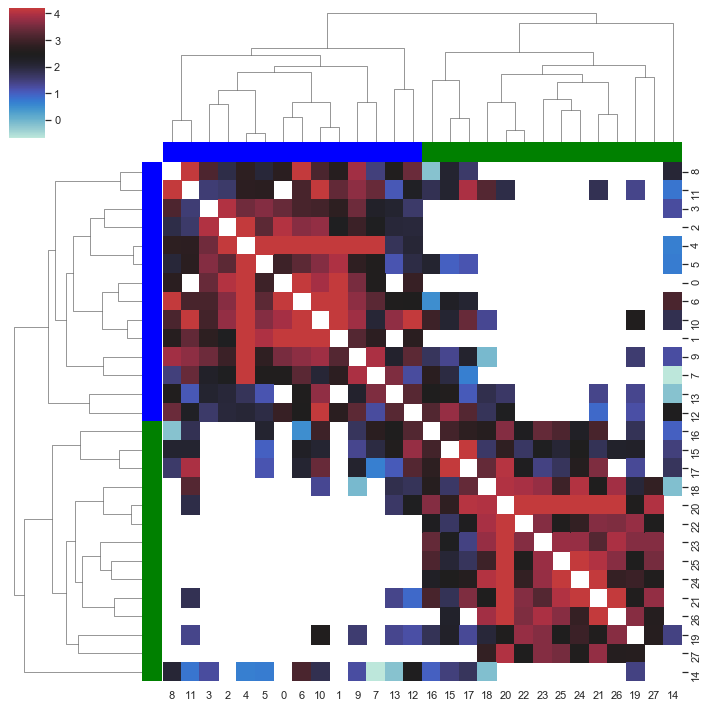

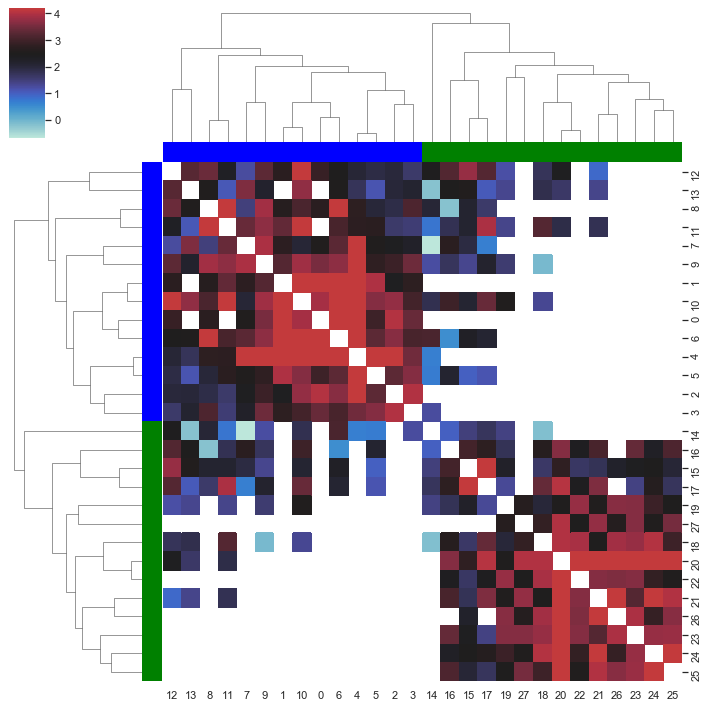

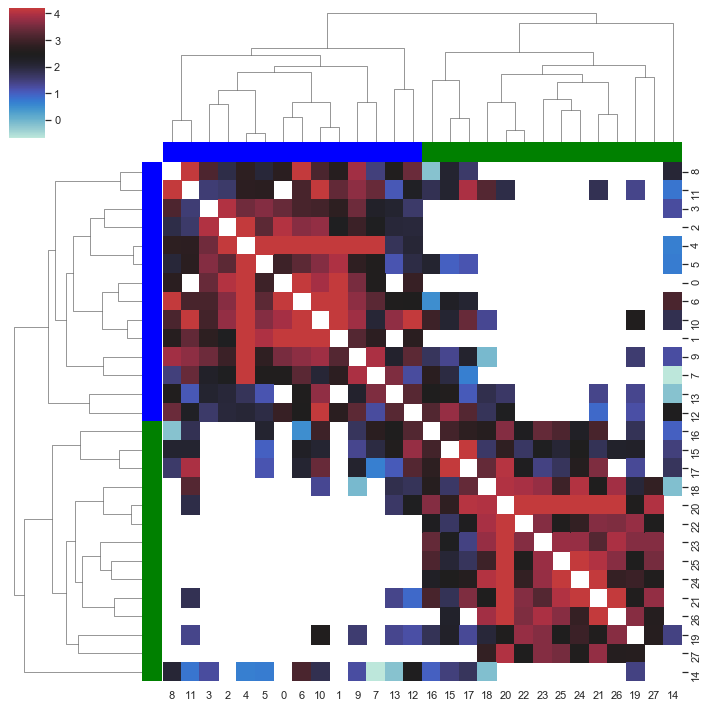

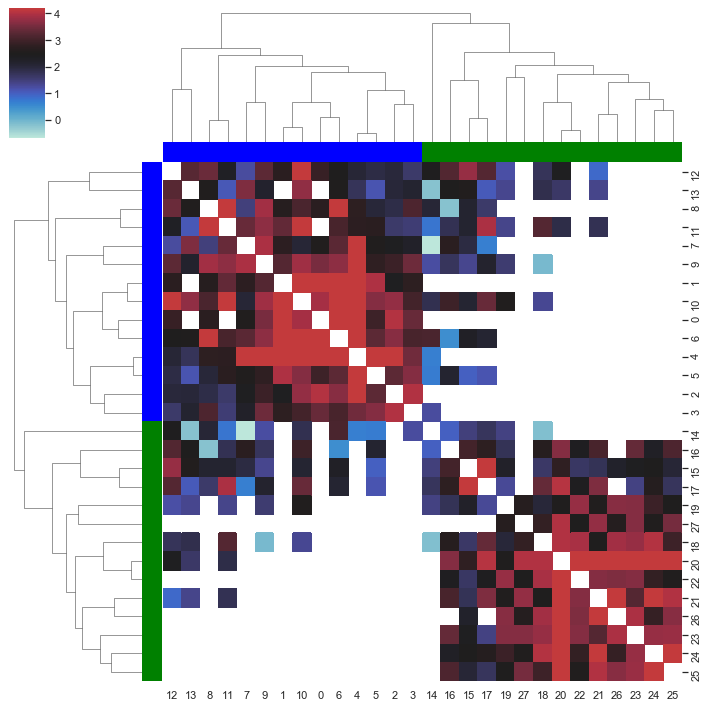

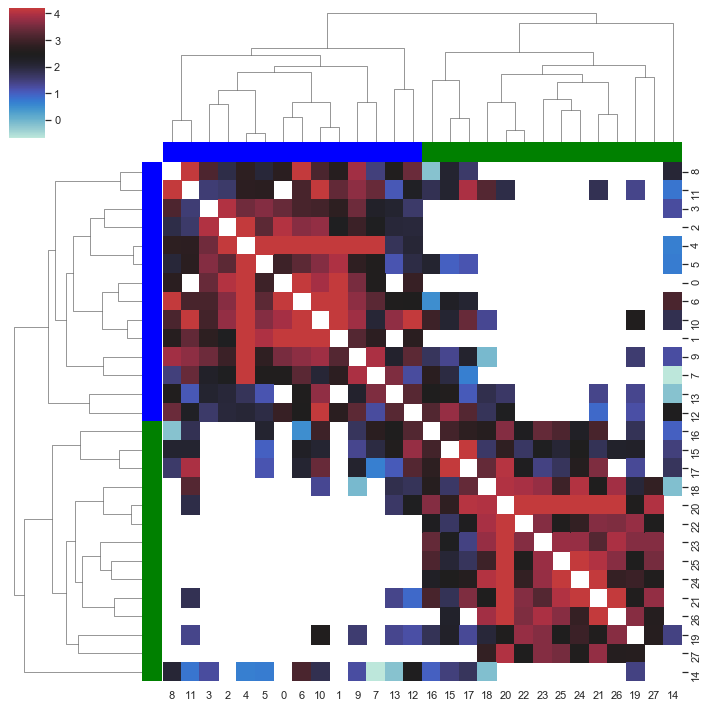

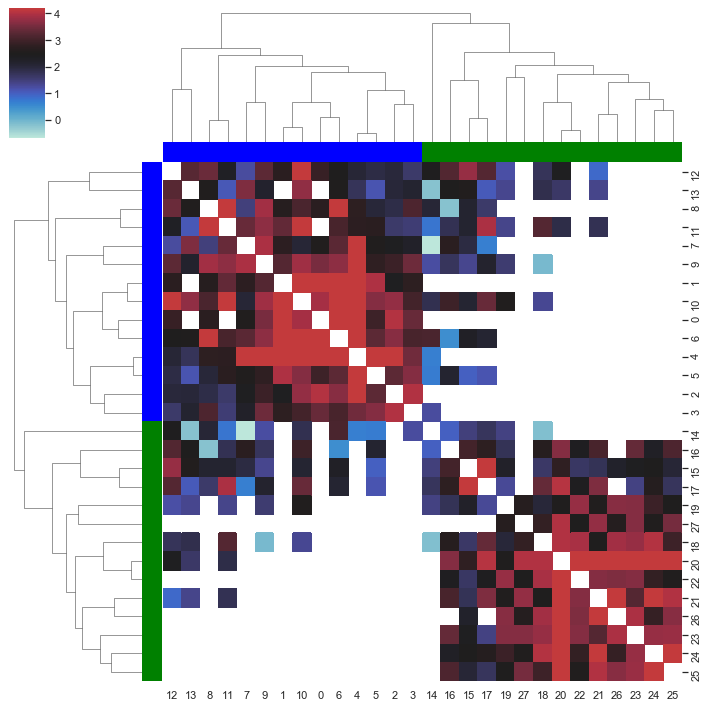

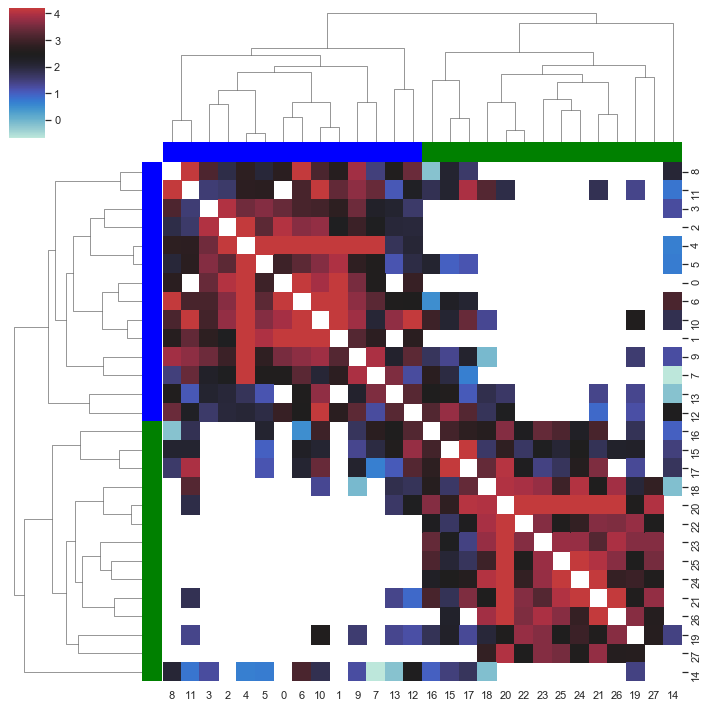

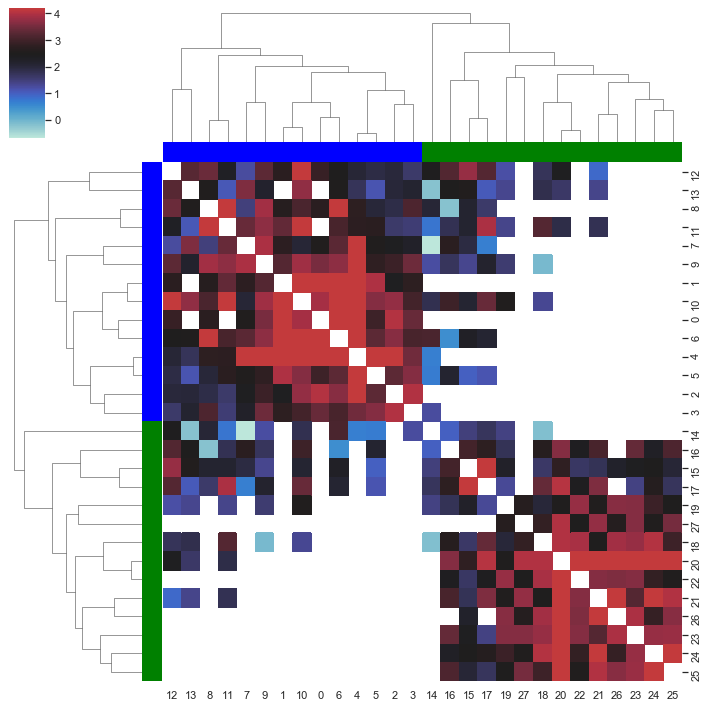

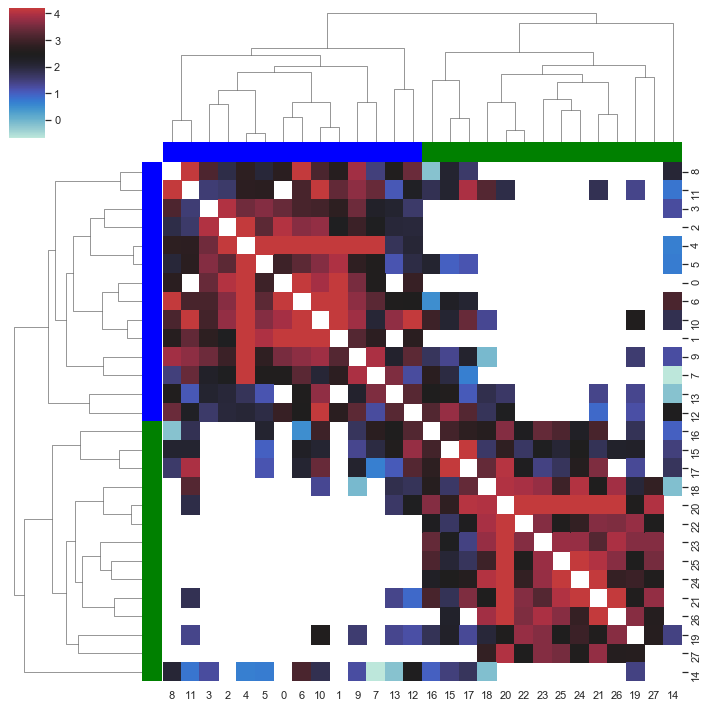

In [201]:
sim_matrix = []
mask = []
valid_pcs_clustered_list2 = copy.copy(valid_pcs_clustered_list)
valid_pcs_clustered_list2.remove('pc_48')  # no soma
valid_pcs_clustered_list2.remove('pc_0')  # very little dendrites in volume

arranged_colors = []
first = True
for pc in valid_pcs_clustered_list2:
    if pc == 'pc_5':
#     if pc == 'pc_9':
        first = False
    if first:
        arranged_colors.append('blue')
    else:
        arranged_colors.append('green')
        
for pc0 in valid_pcs_clustered_list2:
    row = []
    mask_row = []
    for pc1 in valid_pcs_clustered_list2:
        pair = tuple(sorted((pc0, pc1)))
        if pc0 == pc1:
            row.append(0)
            condensed_distance_matrix.append(0)
            mask_row.append(1)
            continue
        if pair not in mat_data:
            row.append(0)
            mask_row.append(1)
            condensed_distance_matrix.append(0)
            continue
        row.append(z_scores[pair])
        mask_row.append(0)
        if j >= i:
            condensed_distance_matrix.append(z_scores[pair])
    sim_matrix.append(row)
    mask.append(mask_row)
mask = np.array(mask)

opt = 1
adjust = 2
# for method in ['complete', 'single', 'average', 'weighted', 'centroid', 'median', 'ward']:
for method in ['complete']:
    for adjust in [.125, 0.25, .375, .5, .625, .75, .875, 1.0, 1.125, 1.25, 1.375, 1.50, 1.625, 1.75, 1.875, 2.0]:
        for opt in [0, 1]:
            condensed_distance_matrix = []
            for i in range(len(sim_matrix)):
                for j in range(i+1, len(sim_matrix)):
                    zscore = 6 - sim_matrix[i][j]
                    if sim_matrix[i][j] == 0:
                        zscore -= adjust
                    condensed_distance_matrix.append(zscore)

            import scipy
            linkage = scipy.cluster.hierarchy.linkage(condensed_distance_matrix,method=method,optimal_ordering=opt)
            cmap = "icefire"; center = 2.5
            g = sns.clustermap(sim_matrix, square=True, mask=mask, cmap=cmap,
                        row_colors=arranged_colors, col_colors=arranged_colors, center=center, vmax=4.2,
                        row_linkage=linkage, col_linkage=linkage,
                          )
            g.savefig(f'{script_n}_hierarchical_method_{method}_opt_{opt}_adj_{adjust}.svg', bbox_inches='tight', transparent=True)

In [131]:
sim_matrix

[[0,
  4.648986610085317,
  4.038288290570942,
  3.4101205308272444,
  5.252880716672482,
  2.979789776697556,
  4.74545194089957,
  2.5550682557657662,
  2.723274735688804,
  3.5672952312043247,
  3.926154353983999,
  0,
  2.897487605283735,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [4.648986610085317,
  0,
  2.3884309915014077,
  2.7818625309723304,
  4.948455873501183,
  4.000919247482013,
  4.3329454525996995,
  2.766174239197882,
  2.6621182826619543,
  3.2267052442055717,
  5.2274853521688005,
  3.359058788927562,
  2.737036722031099,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [4.038288290570942,
  2.3884309915014077,
  0,
  4.0218380781835945,
  4.201707780615954,
  3.3174312703577615,
  3.667097345444221,
  2.3753677438448926,
  1.8960041968878882,
  2.9505628548643315,
  3.7783643015073114,
  1.6094269389321245,
  2.0110141764571807,
  2.0413309205824057,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [14]:
sim_matrix = []
mask = []
for pc0 in valid_pcs_clustered_list:
    row = []
    mask_row = []
    for pc1 in valid_pcs_clustered_list:
        pair = tuple(sorted((pc0, pc1)))
        if pc0 == pc1:
            row.append(0)
            mask_row.append(1)
            continue
        if pair not in mat_data:
            row.append(0)
            mask_row.append(1)
            continue
        row.append(z_scores[pair])
        mask_row.append(0)
    sim_matrix.append(row)
    mask.append(mask_row)
mask = np.array(mask)
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(sim_matrix,
#             center=.5,
            xticklabels=valid_pcs_clustered_list, yticklabels=valid_pcs_clustered_list,
            vmax=4.2,
            square=True,
            mask=mask,
           )

label: 0
pc_57
pc_2
pc_26
pc_1
pc_7
pc_18
pc_17
pc_32
pc_31
purkinje_0
pc_43
pc_25
label: 1
pc_19
pc_53
pc_50
pc_22
pc_20
pc_21
pc_10
pc_23
pc_51
pc_3
label: 2
pc_0
purkinje_1
pc_16
pc_4
pc_28
pc_9
pc_15
pc_48
pc_5


In [12]:
import tools2

loc_db = compress_pickle.load(
    '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/gen_db/pc_soma_locs.gz')

def to_ng_coord(coord):
    return (
        int(coord[0]/16),
        int(coord[1]/16),
        int(coord[2]/40),
        )

for label in set(af.labels_):
    print(f'label: {label}')
    for i, pc in enumerate(valid_pcs):
        if af.labels_[i] != label:
            continue
        if pc not in loc_db:
            print(f'skipping {pc}')
            continue
        print(f'{pc}: {to_ng_coord(loc_db[pc])}')


label: 0
pc_57: (59005, 97577, 196)
pc_2: (77277, 96697, 330)
pc_26: (67342, 97175, 684)
pc_1: (86821, 97570, 508)
pc_7: (82134, 96760, 120)
pc_18: (100133, 94722, 737)
pc_17: (82603, 95590, 1064)
pc_32: (98444, 92975, 1129)
pc_31: (61409, 97132, 470)
purkinje_0: (92054, 96470, 734)
pc_43: (94378, 70328, 1169)
pc_25: (68620, 97798, 1128)
label: 1
pc_19: (131939, 92568, 966)
pc_53: (149464, 89442, 1069)
pc_50: (141136, 89838, 1169)
pc_22: (153737, 89047, 912)
pc_20: (140454, 92728, 835)
pc_21: (146236, 91948, 826)
pc_10: (148546, 89547, 306)
pc_23: (158663, 88187, 619)
pc_51: (136650, 90564, 1169)
pc_3: (138247, 91620, 467)
label: 2
pc_0: (110319, 95553, 258)
purkinje_1: (116385, 93870, 553)
pc_16: (118827, 92848, 774)
pc_4: (103311, 94989, 466)
pc_28: (106666, 92867, 1146)
pc_9: (124782, 92871, 901)
pc_15: (110643, 93711, 713)
pc_48: (118095, 73866, 1169)
pc_5: (94541, 97952, 109)


Height: 4, Aspect: 0.75


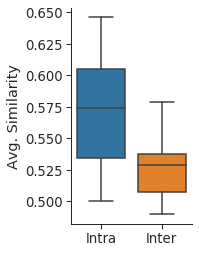

In [52]:
# calculate inter vs intra cluster similarity

intra_similarity = []
inter_similarity = []
intra_similarity2 = []
inter_similarity2 = []
intra_similarity_per_pc = defaultdict(list)
inter_similarity_per_pc = defaultdict(list)

for i, pc0 in enumerate(valid_pcs):
    for j, pc1 in enumerate(valid_pcs):
        if i == j:
            continue
        score = db[pc0][pc1]
        if score is None:
#             continue
            score = 0.5
        if af.labels_[i] != af.labels_[j]:
            inter_similarity_per_pc[i].append(score)
            inter_similarity2.append(score)
        else:
            intra_similarity_per_pc[i].append(score)
            intra_similarity2.append(score)

mpd = MyPlotData()        
for k, l in intra_similarity_per_pc.items():
    intra_similarity.append(sum(l)/len(l))
    mpd.add_data_point(
        avg_similarity=sum(l)/len(l),
        group='Intra',
    )
for k, l in inter_similarity_per_pc.items():
    inter_similarity.append(sum(l)/len(l))
    mpd.add_data_point(
        avg_similarity=sum(l)/len(l),
        group='Inter',
    )

mpd2 = MyPlotData()        
for v in intra_similarity2:
    mpd2.add_data_point(
        avg_similarity=v,
        group='Intra',
    )     
for v in inter_similarity2:
    mpd2.add_data_point(
        avg_similarity=v,
        group='Inter',
    )


importlib.reload(my_plot); my_plot.my_catplot(
    mpd,
    x="group",
    y="avg_similarity",
#     hue="group",
#     ylim=[0, 1],
#     ylim=[.35, .8],
    context='paper',
    kind='box',
    height=4,
    width=3,
    y_axis_label='Avg. Similarity',
    # x_axis_label='# of synapses per connection',
#     save_filename=f'{script_n}_max_dist_{max_dist}_min_length_{min_length}.svg',
    show=True,
    )

Height: 4, Aspect: 1.25


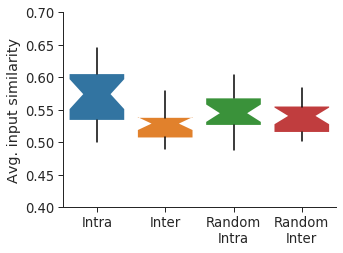

In [53]:
# calculate inter vs intra cluster similarity

intra_similarity_random = []
inter_similarity_random = []
intra_similarity_per_pc = defaultdict(list)
inter_similarity_per_pc = defaultdict(list)

random.seed(2)
random_labels = {}
for i, pc0 in enumerate(valid_pcs):
    random_labels[i] = random.randint(0, 2)

for i, pc0 in enumerate(valid_pcs):
    for j, pc1 in enumerate(valid_pcs):
        if i == j:
            continue
        score = db[pc0][pc1]
        if score is None:
            score = 0.5
        if random_labels[i] != random_labels[j]:
            inter_similarity_per_pc[i].append(score)
        else:
            intra_similarity_per_pc[i].append(score)

mpd_random = MyPlotData()
    
for k, l in intra_similarity_per_pc.items():
    intra_similarity_random.append(sum(l)/len(l))
    mpd_random.add_data_point(
        avg_similarity=sum(l)/len(l),
        group='Random\nIntra',
    )
for k, l in inter_similarity_per_pc.items():
    inter_similarity_random.append(sum(l)/len(l))
    mpd_random.add_data_point(
        avg_similarity=sum(l)/len(l),
        group='Random\nInter',
    )

mpd_all = MyPlotData()
mpd_all.append(mpd)
mpd_all.append(mpd_random)

color = dict(boxes='black', whiskers='black', medians='red', caps='black')
whiskerprops = dict(linestyle='-',linewidth=1.5, color='black')
meanprops = dict(linestyle='-',linewidth=1, color='black')

importlib.reload(my_plot); my_plot.my_catplot(
    mpd_all,
    x="group",
    y="avg_similarity",
#     hue="group",
    ylim=[.4, .7],
    context='paper',
    kind='box',
    height=4,
    width=5,
    linewidth=0,
    y_axis_label='Avg. input similarity',
    # x_axis_label='# of synapses per connection',
    save_filename=f'{script_n}_inter_vs_intra.svg',
    show=True,
    notch=True,
    whiskerprops=whiskerprops,
#     medianprops=meanprops,
    )


In [60]:
import scipy
print('\nIntra-cluster avg. similarity:')
print(scipy.stats.ranksums(intra_similarity, intra_similarity_random))
print('\nInter-cluster avg. similarity:')
print(scipy.stats.ranksums(inter_similarity, inter_similarity_random))
print('\nInter- vs intra-cluster avg. similarity:')
print(scipy.stats.ranksums(intra_similarity, inter_similarity))
print('\nRANDOM Inter- vs intra-cluster avg. similarity:')
print(scipy.stats.ranksums(intra_similarity_random, inter_similarity_random))


Intra-cluster avg. similarity:
RanksumsResult(statistic=3.8312473246008274, pvalue=0.0001274952644776224)

Inter-cluster avg. similarity:
RanksumsResult(statistic=-2.679132100978654, pvalue=0.0073813266938361445)

Inter- vs intra-cluster avg. similarity:
RanksumsResult(statistic=3.6798377420515282, pvalue=0.00023338240387325068)

RANDOM Inter- vs intra-cluster avg. similarity:
RanksumsResult(statistic=-1.4610971625055058, pvalue=0.14398877882348976)


In [59]:
print(len(intra_similarity))
print(len(inter_similarity))
print(len(intra_similarity_random))
print(len(inter_similarity_random))

23
23
805
805


In [56]:

print(scipy.stats.kruskal(intra_similarity, inter_similarity, intra_similarity_random, inter_similarity_random))
import scikit_posthocs
scikit_posthocs.posthoc_dunn([intra_similarity, inter_similarity, intra_similarity_random, inter_similarity_random], p_adjust='bonferroni')


KruskalResult(statistic=17.0491282736854, pvalue=0.0006904886998727849)


,1,2,3,4
1,1.000000,0.000260,0.221205,0.069181
2,0.000260,1.000000,0.271941,0.708796
3,0.221205,0.271941,1.000000,1.000000
4,0.069181,0.708796,1.000000,1.000000


In [57]:

print(scipy.stats.kruskal(intra_similarity, inter_similarity, intra_similarity_random))
import scikit_posthocs
scikit_posthocs.posthoc_dunn([intra_similarity, inter_similarity, inter_similarity_random], p_adjust='bonferroni')


KruskalResult(statistic=14.983746585575664, pvalue=0.000557597438241004)


,1,2,3
1,1.000000,0.000164,0.043183
2,0.000164,1.000000,0.337253
3,0.043183,0.337253,1.000000


In [58]:
# run multiple random shuffles

intra_similarity_random = []
inter_similarity_random = []
mpd_random = MyPlotData()
for n_run in range(35):
    intra_similarity_per_pc = defaultdict(list)
    inter_similarity_per_pc = defaultdict(list)

    random.seed(n_run)
    random_labels = {}
    for i, pc0 in enumerate(valid_pcs):
        random_labels[i] = random.randint(0, 2)

    for i, pc0 in enumerate(valid_pcs):
        for j, pc1 in enumerate(valid_pcs):
            if i == j:
                continue
            score = db[pc0][pc1]
            if score is None:
                score = 0.5
            if random_labels[i] != random_labels[j]:
                inter_similarity_per_pc[i].append(score)
            else:
                intra_similarity_per_pc[i].append(score)

    for k, l in intra_similarity_per_pc.items():
        intra_similarity_random.append(sum(l)/len(l))
        mpd_random.add_data_point(
            avg_similarity=sum(l)/len(l),
            group='Random\nIntra',
        )
    for k, l in inter_similarity_per_pc.items():
        inter_similarity_random.append(sum(l)/len(l))
        mpd_random.add_data_point(
            avg_similarity=sum(l)/len(l),
            group='Random\nInter',
        )
    print(f'{n_run}..', end='')


0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..

Height: 4, Aspect: 1.25


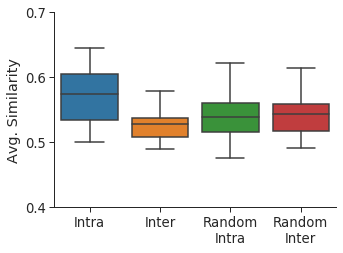

In [12]:

mpd_all = MyPlotData()
mpd_all.append(mpd)
mpd_all.append(mpd_random)

importlib.reload(my_plot); my_plot.my_catplot(
    mpd_all,
    x="group",
    y="avg_similarity",
#     hue="group",
    ylim=[.4, .7],
    y_tick_interval=.1,
    context='paper',
    kind='box',
    height=4,
    width=5,
    y_axis_label='Avg. Similarity',
    # x_axis_label='# of synapses per connection',
#     save_filename=f'{script_n}_max_dist_{max_dist}_min_length_{min_length}.svg',
    show=True,
    )
